# Dynamic Programming

Algorithms that can compute optimal policies (solve RL problems) given a perfect model of the environment as an MDP. Computationally, we require a finite MDP and a small enough problem that we can actually solve it in a reasonable time; this is often called the "tabular" case.

The Bellman optimality equations are
$$ v_*\left(s\right) = \max_a \sum_{s',r} p\left(s',r\middle|s,a\right) \left[r + \gamma v_*\left(s'\right)\right] $$
and
$$ q_*\left(s,a\right) = \sum_{s',r} p\left(s',r\middle|s,a\right) \left[r + \gamma \max_{a'} q_*\left(s', a'\right)\right] $$

RL DP algorithms are derived by converting these into update formulas that can be used to iteratively improve an estimate of the value functions.

# Policy Evaluation / Prediction

Given a policy $\pi$, we would like to compute $v_{\pi}\left(s\right) \forall s \in \mathcal{S}$. We have seen earlier that this is a linear system of equations, but it is often tedious to set up and solve the system. The **iterative policy evaluation algorithm** estimates it via an update formula:

$$ \begin{align*} v_{k+1}\left(s\right) & = \mathbb{E}_{\pi}\left[R_{t+1} + \gamma v_k \left(S_{t+1}\right) \middle| S_t = s \right] \\ & = \sum_a \pi\left(a\middle|s\right) \sum_{s',r} p\left(s',r\middle| s,a\right) \left[r + \gamma v_k\left(s'\right) \right]\end{align*} $$

This looks nearly identical to the Bellman equation for $v_{\pi}$, but the crucial difference is that $v_{k+1}$ on the left-hand side and $v_k$ on the right are not the same function; the former is an incremental update of the latter.

First we will set up the environment/dynamics of the chapter 4 gridworld.

In [1]:
# 0: up, 1: right, 2: down, 3: left
def dynamics(s, a):
    """Dynamics for the episodic gridworld environment.
    Given (s,a), return a list of (s', r, p), possible outcomes.
    """
    if s == 0 or s == 15: # terminal states
        return [(0, 0, 1.0)]
    # else we are not in the terminal states

    if a == 0: # moving up
        if s < 4: # hit top boundary, stay in place
            return [
                (s, -1, 1.0),
            ]
        else: # we are not at the top row
            return [
                (s - 4, -1, 1.0)
            ]
    elif a == 1: # moving right
        if (s+1) % 4 == 0: # hit right boundary
            return [
                (s, -1, 1.0)
            ]
        else: # we are not in the right row
            return [
                (s+1, -1, 1.0),
                ]
        
    elif a == 2: # moving down
        if s >= 12: # hit bottom boundary
            return [
                (s, -1, 1.0)
                ]
        else: # we are not in the bottom row
            return [
                (s + 4, -1, 1.0)
                ]
        
    elif a == 3: # moving left
        if s % 4 == 0: # hit left boundary
            return [
                (s, -1, 1.0)
            ]
        else: # not in leftmost row
            return [
                (s - 1, -1, 1.0)
            ]

In [85]:
from typing import Callable

def plot_gridworld_policy(policy: Callable, ax = None):
    if ax is None:
        _, ax = plt.subplots()

    ax.set(xlim=[-0.5,3.5], ylim=[-0.5,3.5])
    ax.set_xticks(np.arange(-0.5, 3.5, 1))
    ax.set_yticks(np.arange(-0.5, 3.5, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid()

    def state_to_txt_coord(s: int):
        y_coord = 4 - ( s // 4) - 1
        x_coord = s % 4
        return x_coord, y_coord

    arrows = {0: [0,1], 1: [1, 0], 2: [0, -1], 3: [-1, 0]}
    scale = 0.40
    eps = 1e-5
    for s in range(16):
        x_t, y_t = state_to_txt_coord(s)
        for a, p_a_s in policy(s):
            arrow = np.array(arrows[a])
            arrow = scale * p_a_s * arrow
            if any(abs(arrow) > eps):
                ax.arrow(
                    x_t,
                    y_t,
                    arrow[0],
                    arrow[1],
                    head_width=0.05,
                    head_length=0.1,
                    fc='k',
                    ec='k',
                    )
    ax.set_aspect('equal')
    # plt.show()

def plot_v(v: np.ndarray, ax = None):
    if ax is None:
        _, ax = plt.subplots()

    ax.set(xlim=[-0.5,3.5], ylim=[-0.5,3.5])
    ax.set_xticks(np.arange(-0.5, 3.5, 1))
    ax.set_yticks(np.arange(-0.5, 3.5, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid()

    
    def state_to_txt_coord(s: int):
        y_coord = 4 - ( s // 4) - 1
        x_coord = s % 4
        return x_coord, y_coord

    for s in range(len(v)):
        x_t, y_t = state_to_txt_coord(s)
        ax.text(x=x_t, y=y_t, s=f"{v[s]:.1f}")
    ax.set_aspect('equal')
    # plt.show()

In [86]:
def eqr_policy(s):
    """Equiprobable random policy.
    Returns a list of (action_index, probability) tuples.
    Note that s is unused since this is random policy
    """
    return [
        (0, 0.25),
        (1, 0.25),
        (2, 0.25),
        (3, 0.25),
    ]

In [87]:
import numpy as np
import matplotlib.pyplot as plt

In [88]:
v_km1 = np.zeros(16)
v_k = np.zeros(16)

tol = 0.001
max_iter = 200
iter_ = 1

while iter_ <= max_iter:
    del_ = 0
    for s in range(16):
        for a, p_a_s in eqr_policy(s):
            for sp, r, p_spr_sa in dynamics(s, a):
                v_k[s] += p_a_s * p_spr_sa * (r + v_km1[sp])
        del_ = np.max([del_, np.abs(v_k[s] - v_km1[s])])
    v_km1 = v_k.copy()
    v_k = np.zeros(16)

    if del_ < tol:
        print(f"converged on iteration {iter_}")
        break

    iter_ += 1

converged on iteration 131


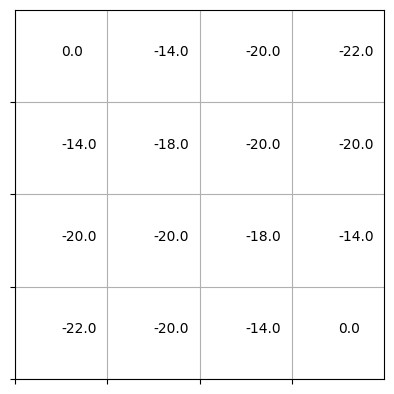

In [89]:
plot_v(v_km1)

In [90]:
def calc_q_from_v(v):
    """Given a state-value function v and the problem dynamics,
    compute the corresponding action-value function.
    """
    gamma = 1
    v_f = v.flatten()
    q = np.zeros((16, 4)) # states, actions
    for s in range(16):
        for a in range(4):
            for sp, r, p_sp_r in dynamics(s, a):
                q[s, a] += (r + gamma * v_f[sp]) * p_sp_r
    return q


def calc_greedy_policy_from_v(v):
    """Given a state-value function, calculate a greedy policy."""
    # get action-value function
    q = calc_q_from_v(v)

    def greedy_policy(s):
        # Greedy policy assigns nonzero probability only to actions that
        # give maximal q(s,a)
        exp_return_a = [q[s,a] for a in range(4)]

        # then take the max
        opt_actions = np.where(exp_return_a == np.max(exp_return_a))[0]
        p_ = 1/len(opt_actions)
        return [(oa, p_) for oa in opt_actions]
    return greedy_policy

In [91]:
q.shape

(16, 4)

In [92]:
policy_greedy = calc_greedy_policy_from_v(v_km1)

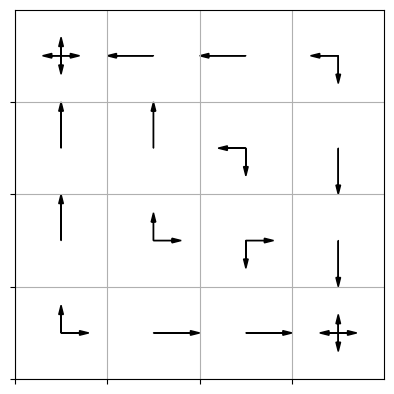

In [93]:
plot_gridworld_policy(policy_greedy)

# Car example

State is $\left(s_1, s_2\right) \in \left[0, 20\right]^2$

Actions are $a \in \left[-5, 5\right]$

A policy is $ \pi\left(a\middle|s\right) $

The dynamics are given by

$$ \begin{align*} p_1\left(n_{req}\right) = \frac{3^n}{n!}\exp^{-3} \\ p_2\left(n_{req}\right) = \frac{4^n}{n!}\exp^{-4} \\ p_1\left(n_{ret}\right) = \frac{3^n}{n!}\exp^{-3} \\ p_2\left(n_{ret}\right) = \frac{2^n}{n!}\exp^{-2}   \end{align*} $$

In [111]:
from math import factorial
def _poisson_pdf(lambda_, n):
    return (lambda_ ** n) * np.exp(-lambda_) / factorial(n)

def p1_req(n):
    """Probability of n requests from location 1."""
    return _poisson_pdf(3, n)
def p1_ret(n):
    """Probability of n returns to location 1."""
    return _poisson_pdf(3, n)
def p2_req(n):
    """Probability of n requests from location 2."""
    return _poisson_pdf(4, n)
def p2_ret(n):
    """Probability of n returns to location 2."""
    return _poisson_pdf(2, n)


actions = zip(range(11), range(-5,6,1))
def dynamics(s, a):
    """Return [(sp, r, p_spr_sa)]"""

    # loop over every scenario
    for n_req_1 in range(21):
        for n_req_2 in range(21):
            for n_ret_1 in range(21):
                for n_ret_2 in range(21):

                    # calculate the return (deterministic now)
                    r = 10 * np.max([0, s[0] - n_req_1]) + 10 * np.max([0, s[1] - n_req_2]) - 2 * actions[a]

                    # calculate the new state
                    s1 = (s[0] - np.max([0, s[0] - n_req_1])) - actions[a] + n_ret_1


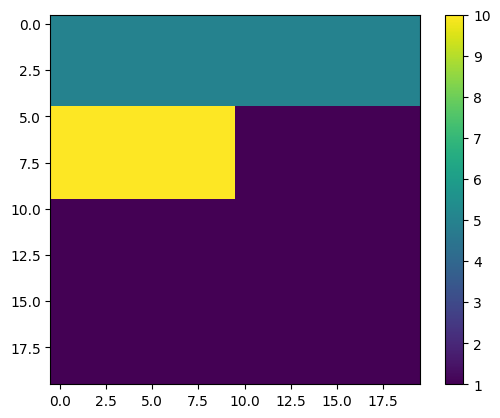

In [104]:
Z = np.ones((20, 20))
Z[:10, :10] = 10
Z[:5, :] = 5

fig, ax = plt.subplots()
img = ax.imshow(Z)
plt.colorbar(img)
plt.show()